In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import statsmodels.formula.api as smf

import pylab as pl
%pylab inline

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

Populating the interactive namespace from numpy and matplotlib


### Set up the data

In [2]:
# read in cleaned data
df = gp.read_file('data/cb_dist/cb_dist.shp')
df.cb = df.cb.astype('int')
cb_rides = pd.read_csv('data/cb_rides.csv')
demo = pd.read_csv('data/demo.csv')

In [3]:
# merge distance and number of rides tables
df = df.merge(cb_rides, left_on = 'cb', right_on = 'BCTCB2010', )

In [4]:
# create a geoid at the census block group level
df['geoid'] = [str(i)[0:12] for i in df.cb ]

In [5]:
# dissolve to the block group level
df = df.dissolve(by = 'geoid', as_index = False)
df.geoid = df.geoid.astype('int')

In [6]:
# merge in the demographics data
df = df.merge(demo, on = 'geoid')

In [7]:
# combine no vehicle units into one column

df['no_vehicle'] = df['no_vehicle_own'] + df['no_vehicle_rent']

# calculate nonlinearities
df['dist_tohom2'] = df['dist_tohom']**2
df['log_workers'] = np.log10(df['workers'])

### Develop a simple model first

In [21]:
# regress number of rides on average commute distance
lm = smf.ols('n_rides ~ dist_towor + dist_tohom', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     13.24
Date:                Tue, 06 Dec 2016   Prob (F-statistic):           5.22e-06
Time:                        17:46:17   Log-Likelihood:                -1465.2
No. Observations:                 148   AIC:                             2936.
Df Residuals:                     145   BIC:                             2945.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     1.2e+04   1760.965      6.814      0.000      8518.032  1.55e+04
dist_towor -4221.5591    911.260     -4.633      0.000     -6022.627 -2420.491
dist_tohom  1782.7821    514.494      3.465      0.001       765.906  2799.658
==============================================================================
Omnibus:                       66.864   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.502
Skew:                           1.733   Prob(JB):                     5.37e-51
Kurtosis:                       8.053   Cond. No.                         16.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Investigation

It seems weird that there is a significant positive coefficient on distance to home. What's going on?

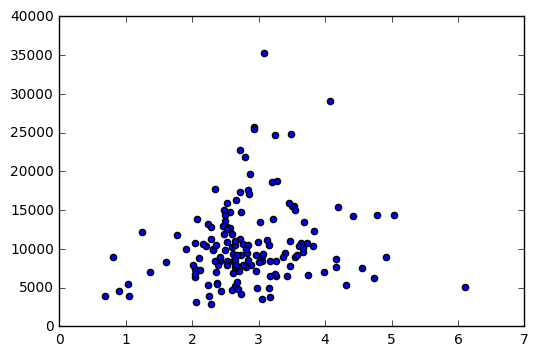

In [9]:
pl.scatter(df['dist_tohom'], df['n_rides'])

There appears to be some non linearity! Can we improve the model with polynomials?

In [10]:
lm = smf.ols('n_rides ~ dist_towor + dist_tohom2 + dist_tohom', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     9.404
Date:                Tue, 06 Dec 2016   Prob (F-statistic):           1.03e-05
Time:                        17:42:14   Log-Likelihood:                -1464.4
No. Observations:                 148   AIC:                             2937.
Df Residuals:                     144   BIC:                             2949.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    7885.4397   3685.492      2.140      0.034       600.788  1.52e+04
dist_towor  -3822.7812    962.059     -3.974      0.000     -5724.363 -1921.200
dist_tohom2  -425.3701    335.035     -1.270      0.206     -1087.591   236.851
dist_tohom   4322.2776   2065.027      2.093      0.038       240.598  8403.958
==============================================================================
Omnibus:                       65.008   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.599
Skew:                           1.696   Prob(JB):                     9.25e-48
Kurtosis:                       7.860   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Look at a more extensive model

In [11]:
lm = smf.ols('n_rides ~ dist_tohom + dist_tohom2 + dist_towor + \
pop + log_workers + bike + income_pc + commute_time + no_vehicle', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     3.993
Date:                Tue, 06 Dec 2016   Prob (F-statistic):           0.000149
Time:                        17:42:15   Log-Likelihood:                -1460.5
No. Observations:                 148   AIC:                             2941.
Df Residuals:                     138   BIC:                             2971.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     9136.0314   4109.143      2.223      0.028      1011.008  1.73e+04
dist_tohom    3750.3239   2093.625      1.791      0.075      -389.409  7890.057
dist_tohom2   -407.3676    336.387     -1.211      0.228     -1072.506   257.771
dist_towor   -4017.3767   1100.796     -3.650      0.000     -6193.985 -1840.769
pop             -0.1475      1.170     -0.126      0.900        -2.461     2.166
log_workers     -0.4803    650.888     -0.001      0.999     -1287.484  1286.524
bike            -5.1742     19.229     -0.269      0.788       -43.196    32.847
income_pc        0.0041      0.011      0.394      0.694        -0.017     0.025
commute_time     4.6497      2.351      1.978      0.050         0.001     9.299
no_vehicle      -5.7034      3.025     -1.885      0.062       -11.686     0.279
==============================================================================
Omnibus:                       59.456   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.474
Skew:                           1.578   Prob(JB):                     1.07e-39
Kurtosis:                       7.376   Cond. No.                     1.08e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This overall model is not much improved but there is reason to believe some of these variables may be useful

### Feature Selection

In [12]:
df.corr()

,geoid,cb,dist_tohom,dist_towor,workers,BCTCB2010,n_rides,pop,bike,commute_time,income_pc,no_vehicle_rent,no_vehicle_own,no_vehicle,dist_tohom2,log_workers
geoid,1.000000,1.000000,-0.008523,-0.276126,0.232762,1.000000,0.193665,-0.149896,-0.114251,-0.004937,0.153329,-0.040990,0.019164,-0.034127,-0.066404,0.331020
cb,1.000000,1.000000,-0.008523,-0.276126,0.232762,1.000000,0.193665,-0.149896,-0.114251,-0.004937,0.153329,-0.040990,0.019164,-0.034127,-0.066404,0.331020
dist_tohom,-0.008523,-0.008523,1.000000,0.284006,-0.034144,-0.008523,0.171185,0.050070,-0.129175,0.156619,0.204938,-0.041592,0.169844,0.019198,0.969227,0.041633
dist_towor,-0.276126,-0.276126,0.284006,1.000000,-0.289228,-0.276126,-0.290580,0.355621,0.063540,0.224180,-0.132188,0.159097,-0.018259,0.152545,0.352325,-0.374773
workers,0.232762,0.232762,-0.034144,-0.289228,1.000000,0.232762,0.171012,-0.170085,-0.150719,-0.062026,0.048599,-0.054125,0.014756,-0.048838,-0.032954,0.721416
BCTCB2010,1.000000,1.000000,-0.008523,-0.276126,0.232762,1.000000,0.193665,-0.149896,-0.114251,-0.004937,0.153329,-0.040990,0.019164,-0.034127,-0.066404,0.331020
n_rides,0.193665,0.193665,0.171185,-0.290580,0.171012,0.193665,1.000000,-0.055394,-0.082130,0.072272,0.210004,-0.037180,0.057899,-0.016455,0.114974,0.191236
pop,-0.149896,-0.149896,0.050070,0.355621,-0.170085,-0.149896,-0.055394,1.000000,0.204964,0.866411,-0.099163,0.776086,0.164394,0.834836,0.080559,-0.156057
bike,-0.114251,-0.114251,-0.129175,0.063540,-0.150719,-0.114251,-0.082130,0.204964,1.000000,0.129875,-0.136345,0.171141,0.033624,0.183155,-0.130620,-0.125334
commute_time,-0.004937,-0.004937,0.156619,0.224180,-0.062026,-0.004937,0.072272,0.866411,0.129875,1.000000,0.134727,0.819251,0.232521,0.902378,0.160964,0.047030


### Another model following simple feature selection

In [18]:
lm = smf.ols('n_rides ~ dist_tohom2 + dist_tohom + dist_towor + commute_time + no_vehicle', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     7.309
Date:                Tue, 06 Dec 2016   Prob (F-statistic):           4.02e-06
Time:                        17:44:14   Log-Likelihood:                -1460.7
No. Observations:                 148   AIC:                             2933.
Df Residuals:                     142   BIC:                             2951.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     9379.6548   3702.927      2.533      0.012      2059.668  1.67e+04
dist_tohom2   -417.0638    329.156     -1.267      0.207     -1067.744   233.616
dist_tohom    3881.6634   2034.650      1.908      0.058      -140.456  7903.782
dist_towor   -4188.3149    962.864     -4.350      0.000     -6091.716 -2284.914
commute_time     4.8137      1.805      2.666      0.009         1.245     8.382
no_vehicle      -6.2780      2.800     -2.242      0.027       -11.813    -0.743
==============================================================================
Omnibus:                       59.909   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.316
Skew:                           1.596   Prob(JB):                     1.15e-39
Kurtosis:                       7.346   Cond. No.                     1.30e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
df['pred'] = lm.predict()
df['resid'] = df['n_rides'] - df['pred']

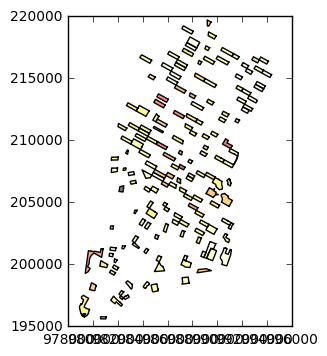

In [29]:

df.plot(column = 'resid', cmap = 'hot_r')